<a href="https://colab.research.google.com/github/ViktoriaM28/-Data-Science/blob/main/%D0%9B%D0%B0%D0%B1_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель и задачи работы:**


1.   Познакомиться с понятием «большие данные» и способами их обработки;
2.   Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных;
3.Получить навыки выполнения разведочного анализа данных использованием pyspark.



Импорт необходимых библиотек

In [ ]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

Установка Pyspark

In [1]:
! pip install pyspark

In [5]:
# Импорт модулей, связанных с PySpark.
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Инициализировать сеанс Spark.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'online_sales_dataset.csv' # Загрузите данные в текущий каталог Colab.
# filename_data = 'data/endomondoHR.json' # Загрузите данные в каталог data/  при работе в Docker.
# Загрузите основной набор данных в фрейм данных pyspark.
df = spark.read.csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


**Просмотр набора данных**

In [6]:
df.show(5)

+---------+---------+-----------+--------+----------------+---------+----------+-----------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|      _c0|      _c1|        _c2|     _c3|             _c4|      _c5|       _c6|        _c7|     _c8|          _c9|        _c10|       _c11|        _c12|        _c13|            _c14|             _c15|         _c16|
+---------+---------+-----------+--------+----------------+---------+----------+-----------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|InvoiceNo|StockCode|Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|    Country|Discount|PaymentMethod|ShippingCost|   Category|SalesChannel|ReturnStatus|ShipmentProvider|WarehouseLocation|OrderPriority|
|   221958| SKU_1964|  White Mug|      38|2020-01-01 00:00|     1.71|   37039.0|  Australia|    0.47|Bank Transfer|       10.79|    Appa

### **Описание столбцов датасета:**

*InvoiceNo* -
Уникальный идентификатор для каждой транзакции продажи (счета-фактуры)

*StockCode* -
Код, обозначающий единицу хранения товара на складе (SKU).

*Description* -
Краткое описание продукта.


*Quantity* -
Количество единиц товара, проданного в ходе транзакции.

*InvoiceDate* -
Дата и время, когда была зарегистрирована продажа.

*UnitPrice* -
Цена за единицу товара в валюте транзакции.


*CustomerID* -
Уникальный идентификатор для каждого клиента.

*Country* -
Страна клиента.

*Discount* -
Скидка, применяемая к сделке, если таковая имеется.

*PaymentMethod* -
Способ оплаты, использованный для транзакции (например, PayPal, банковский перевод).

*ShippingCost* -
Стоимость доставки по транзакции.

*Category* -
Категория, к которой относится товар (например, электроника, одежда).

*SalesChannel* -
Канал, через который была осуществлена продажа (например, онлайн, в магазине).

*ReturnStatus* -
Указывает, был ли товар возвращен или нет.

*ShipmentProvider* -
Поставщик, ответственный за доставку заказа (например, UPS, FedEx).

*WarehouseLocation* -
Местоположение склада, с которого был выполнен заказ.

*OrderPriority* -
Уровень приоритета заказа (например, Высокий, средний, низкий).

Изменение наименования столбцов

In [11]:
df = df \
    .withColumnRenamed("_c0", "InvoiceNo") \
    .withColumnRenamed("_c1", "StockCode") \
    .withColumnRenamed("_c2", "Description") \
    .withColumnRenamed("_c3", "Quantity") \
    .withColumnRenamed("_c4", "InvoiceDate") \
    .withColumnRenamed("_c5", "UnitPrice") \
    .withColumnRenamed("_c6", "CustomerID") \
    .withColumnRenamed("_c7", "Country") \
    .withColumnRenamed("_c8", "Discount") \
    .withColumnRenamed("_c9", "PaymentMethod") \
    .withColumnRenamed("_c10", "ShippingCost") \
    .withColumnRenamed("_c11", "Category") \
    .withColumnRenamed("_c12", "SalesChannel") \
    .withColumnRenamed("_c13", "ReturnStatus") \
    .withColumnRenamed("_c14", "ShipmentProvider") \
    .withColumnRenamed("_c15", "WarehouseLocation") \
    .withColumnRenamed("_c16", "OrderPriority")

# Проверка нового наименования столбцов
df.printSchema()
df.show()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- ShippingCost: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- SalesChannel: string (nullable = true)
 |-- ReturnStatus: string (nullable = true)
 |-- ShipmentProvider: string (nullable = true)
 |-- WarehouseLocation: string (nullable = true)
 |-- OrderPriority: string (nullable = true)

+---------+---------+--------------+--------+----------------+---------+----------+--------------+-----------------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|InvoiceNo|StockCode|   Descriptio

Удаление перовй строки, так как она содержит наименования столбцов

In [13]:
first_row = df.limit(1)

# Удаление первой строки
df_filtered = df.exceptAll(first_row)

# Показать результат
print("DataFrame после удаления первой строки:")
df_filtered.show()

DataFrame после удаления первой строки:
+---------+---------+--------------+--------+----------------+---------+----------+--------------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|InvoiceNo|StockCode|   Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|Discount|PaymentMethod|ShippingCost|   Category|SalesChannel|ReturnStatus|ShipmentProvider|WarehouseLocation|OrderPriority|
+---------+---------+--------------+--------+----------------+---------+----------+--------------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|   818315| SKU_1463|      Notebook|      14|2020-01-01 21:00|    66.89|   16604.0|        Norway|    0.42|      paypall|       15.05|  Furniture|      Online|Not Returned|           FedEx|           Berlin|         High|
|   358795| SKU_1023|    Headphones|      30|2020-01-02 08:00|    99.31|

Проверка типа данных столбцов

In [16]:
import pandas as pd

In [17]:

df_filtered.printSchema()
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- ShippingCost: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- SalesChannel: string (nullable = true)
 |-- ReturnStatus: string (nullable = true)
 |-- ShipmentProvider: string (nullable = true)
 |-- WarehouseLocation: string (nullable = true)
 |-- OrderPriority: string (nullable = true)



,Column Name,Data type
0,InvoiceNo,string
1,StockCode,string
2,Description,string
3,Quantity,string
4,InvoiceDate,string
5,UnitPrice,string
6,CustomerID,string
7,Country,string
8,Discount,string
9,PaymentMethod,string


Тип данных всех столбцов - строка. Следует заменить типы данных.

In [18]:
df_filtered1 = df_filtered.withColumn("InvoiceDate", df_filtered["InvoiceDate"].cast(TimestampType())) \
       .withColumn("InvoiceNo", df_filtered["InvoiceNo"].cast(IntegerType())) \
       .withColumn("Quantity", df_filtered["Quantity"].cast(IntegerType())) \
       .withColumn("UnitPrice", df_filtered["UnitPrice"].cast(DoubleType())) \
       .withColumn("CustomerID", df_filtered["CustomerID"].cast(IntegerType())) \
       .withColumn("Discount", df_filtered["Discount"].cast(DoubleType())) \
       .withColumn("ShippingCost", df_filtered["ShippingCost"].cast(DoubleType()))

# Показать DataFrame после изменения типов и новые типы столбцов
print("DataFrame после изменения типов столбцов:")
df_filtered1.printSchema()
pd.DataFrame(df_filtered1.dtypes, columns = ['Column Name','Data type'])

DataFrame после изменения типов столбцов:
root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Discount: double (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- ShippingCost: double (nullable = true)
 |-- Category: string (nullable = true)
 |-- SalesChannel: string (nullable = true)
 |-- ReturnStatus: string (nullable = true)
 |-- ShipmentProvider: string (nullable = true)
 |-- WarehouseLocation: string (nullable = true)
 |-- OrderPriority: string (nullable = true)



,Column Name,Data type
0,InvoiceNo,int
1,StockCode,string
2,Description,string
3,Quantity,int
4,InvoiceDate,timestamp
5,UnitPrice,double
6,CustomerID,int
7,Country,string
8,Discount,double
9,PaymentMethod,string


In [19]:
df_filtered.show()

+---------+---------+--------------+--------+----------------+---------+----------+--------------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|InvoiceNo|StockCode|   Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|Discount|PaymentMethod|ShippingCost|   Category|SalesChannel|ReturnStatus|ShipmentProvider|WarehouseLocation|OrderPriority|
+---------+---------+--------------+--------+----------------+---------+----------+--------------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|   818315| SKU_1463|      Notebook|      14|2020-01-01 21:00|    66.89|   16604.0|        Norway|    0.42|      paypall|       15.05|  Furniture|      Online|Not Returned|           FedEx|           Berlin|         High|
|   358795| SKU_1023|    Headphones|      30|2020-01-02 08:00|    99.31|   61358.0|United Kingdom|    0.31|  Cre

**Поиск пропущенных значений**

In [21]:
import numpy as np

In [22]:
string_columns = ['StockCode', 'Description', 'Country', 'PaymentMethod', 'Category', 'SalesChannel', 'ReturnStatus', 'ShipmentProvider', 'WarehouseLocation', 'OrderPriority']
numeric_columns = ['InvoiceNo','Quantity', 'UnitPrice','CustomerID','Discount','ShippingCost']
array_columns = ['InvoiceDate']
missing_values = {}
for index, column in enumerate(df_filtered1.columns):
    if column in string_columns:    # проверить столбцы строк со значениями None и Null
#         missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
#         missing_values.update({column: missing_count})
        missing_count = df_filtered1.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df_filtered1.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})

missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority
0,0,0,0,0,0,0,0,498,0,0,0,0,0,0,3485,0


Замена None и Null на 0 в столбце Discount

In [23]:
df_filtered1 = df_filtered.fillna({'Discount': 0})

# Показать результат
print("DataFrame после замены None и Null на 0 в столбце Discount:")
df_filtered1.show()

DataFrame после замены None и Null на 0 в столбце Discount:
+---------+---------+--------------+--------+----------------+---------+----------+--------------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|InvoiceNo|StockCode|   Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|Discount|PaymentMethod|ShippingCost|   Category|SalesChannel|ReturnStatus|ShipmentProvider|WarehouseLocation|OrderPriority|
+---------+---------+--------------+--------+----------------+---------+----------+--------------+--------+-------------+------------+-----------+------------+------------+----------------+-----------------+-------------+
|   818315| SKU_1463|      Notebook|      14|2020-01-01 21:00|    66.89|   16604.0|        Norway|    0.42|      paypall|       15.05|  Furniture|      Online|Not Returned|           FedEx|           Berlin|         High|
|   358795| SKU_1023|    Headphones|      30|2020-01

**Расчет статистических показателей**

In [67]:
df_filtered1.describe().show()

+-------+------------------+---------+--------------+------------------+----------------+------------------+------------------+-------------+-------------------+-------------+------------------+-----------+------------+------------+----------------+-----------------+-------------+
|summary|         InvoiceNo|StockCode|   Description|          Quantity|     InvoiceDate|         UnitPrice|        CustomerID|      Country|           Discount|PaymentMethod|      ShippingCost|   Category|SalesChannel|ReturnStatus|ShipmentProvider|WarehouseLocation|OrderPriority|
+-------+------------------+---------+--------------+------------------+----------------+------------------+------------------+-------------+-------------------+-------------+------------------+-----------+------------+------------+----------------+-----------------+-------------+
|  count|             49782|    49782|         49782|             49782|           49782|             49782|             44804|        49782|             

In [65]:
from pyspark.sql.functions import col, avg, percentile_approx

quartiles = df_filtered1.select(
    percentile_approx("ShippingCost", 0.25).alias("1st_quartile"),
    percentile_approx("ShippingCost", 0.5).alias("2nd_quartile"),
    percentile_approx("ShippingCost", 0.75).alias("3rd_quartile")
)

quartiles.show()

+------------+------------+------------+
|1st_quartile|2nd_quartile|3rd_quartile|
+------------+------------+------------+
|       11.22|       17.49|       23.72|
+------------+------------+------------+



In [31]:
import matplotlib as plt
import math
import matplotlib.pyplot as plt


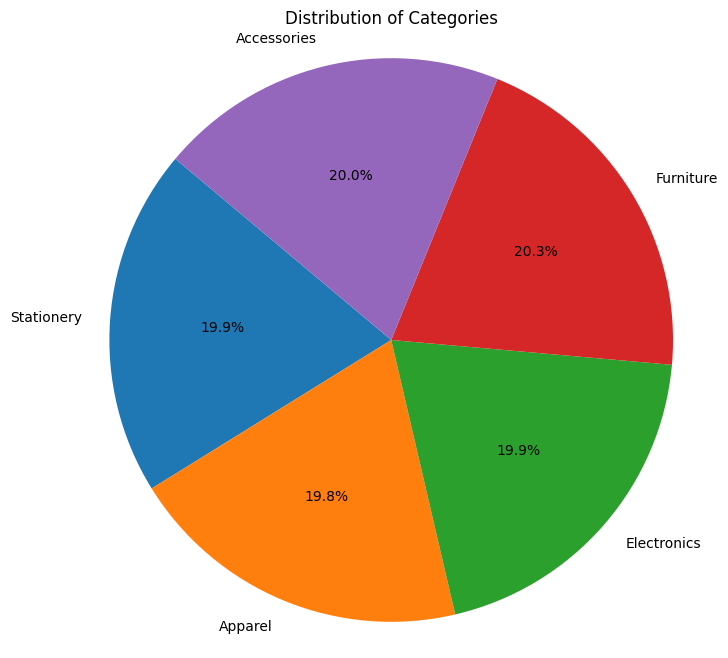

In [48]:
category_counts = df_filtered1.groupBy('Category').count().toPandas()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(category_counts['count'], labels=category_counts['Category'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Categories')
plt.axis('equal')
plt.show()

Из графика видно что продажи по категориям распределены практически в равных долях

In [57]:
import plotly.express as px
import seaborn as sns

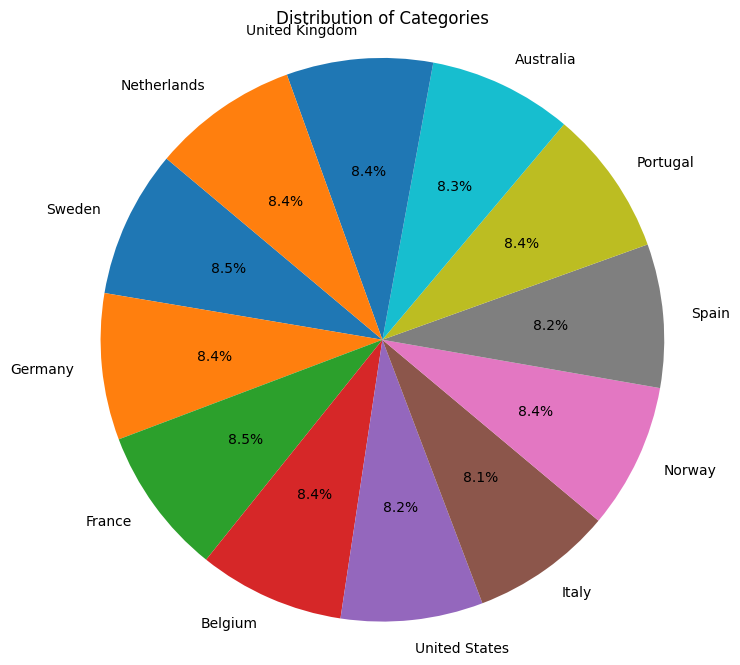

In [64]:
category_counts = df_filtered1.groupBy('Country').count().toPandas()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(category_counts['count'], labels=category_counts['Country'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Counries')
plt.axis('equal')
plt.show()